# AutoML Training on Semantic Model

##### **Goal:** Train a machine learning model to predict delivery times using:
##### - Power BI Semantic Model (via Semantic Link)
##### - DAX queries with RELATED() function
##### - FLAML AutoML for model selection
##### - MLflow for experiment tracking

### ⭐ 1. Imports

- pandas: dataframe manipulation
- mlflow: experiment tracking and model registry
- AutoML (FLAML): automatic model selection / tuning
- sklearn: train/test split + evaluation metrics
- sempy.fabric: read tables from Power BI semantic mode

In [14]:
# Data manipulation
import pandas as pd
import numpy as np

# Machine Learning
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error

# Experiment tracking
import mlflow
from mlflow.tracking import MlflowClient

# Semantic Link - Connect to Power BI
import sempy.fabric as fabric

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ All libraries imported")


StatementMeta(, 5c6299cf-8d23-42ef-839e-a4db63519be4, 16, Finished, Available, Finished)

✅ All libraries imported


### ⭐ 2. Load Data Using DAX

Update DATASET_NAME if your semantic model has a different name. 

Instead of manual pandas joins, we use **DAX with RELATED()** to leverage relationships already defined in Power BI.

**Why this approach?**
- ✅ Same DAX you use in Power BI
- ✅ No manual join keys
- ✅ No duplicate columns
- ✅ Single source of truth

 We pull the three core tables:
- shipments: fact table with delivery_days_actual + dates
- carriers: carrier-level attributes (speed_factor, name)
- warehouses: warehouse origin region

In [15]:
# Semantic model name
DATASET = "delivery semantic model"

# DAX query: Get shipments with related carrier and warehouse info
dax_query = """
EVALUATE
ADDCOLUMNS(
    shipments,
    "carrier_name", RELATED(carriers[carrier_name]),
    "carrier_speed_factor", RELATED(carriers[speed_factor]),
    "warehouse_name", RELATED(warehouses[warehouse_name])
)
"""

# Execute DAX query
df = fabric.evaluate_dax(dataset=DATASET, dax_string=dax_query)

# Clean column names (DAX adds table prefixes like 'shipments[column]')
df.columns = [col.split('[')[-1].replace(']', '') for col in df.columns]

print(f"✅ Loaded {len(df):,} shipments")
print(f"✅ Columns: {df.shape[1]}")
df.head()

StatementMeta(, 5c6299cf-8d23-42ef-839e-a4db63519be4, 17, Finished, Available, Finished)

✅ Loaded 5,000 shipments
✅ Columns: 17


,order_to_ship_days,ship_dayofweek,ship_month,distance_band,service_level,order_date,ship_date,delivery_date,delivery_days_actual,shipment_id,carrier_id,warehouse_id,origin_region,destination_region,carrier_name,carrier_speed_factor,warehouse_name
0,1.002862,1,6,Medium,Fast,2024-06-17,2024-06-18 00:04:07.246667,2024-06-19 18:22:08.796667,1.762518,626,3,4,Northeast,West,SlowShip,1.3,Northeast DC
1,1.910727,6,4,Medium,Ground,2024-04-27,2024-04-28 21:51:26.830000,2024-05-01 22:24:17.460000,3.022808,627,2,1,West,South,StandardShip,1.0,West DC
2,1.701361,2,1,Medium,Fast,2024-01-16,2024-01-17 16:49:57.600000,2024-01-18 17:53:54.883333,1.044413,628,2,3,South,West,StandardShip,1.0,South DC
3,1.353996,5,4,Short,Ground,2024-04-12,2024-04-13 08:29:45.230000,2024-04-14 15:02:50.980000,1.272983,629,2,1,West,Northeast,StandardShip,1.0,West DC
4,1.149674,1,6,Long,Fast,2024-06-24,2024-06-25 03:35:31.806667,2024-06-28 02:11:02.203333,2.941324,630,2,1,West,Northeast,StandardShip,1.0,West DC


In [17]:
print("\n=== Dataset Summary ===")
print(f"Total rows: {len(df):,}")
print(f"Columns: {df.shape[1]}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nData types:")
print(df.dtypes)

StatementMeta(, 5c6299cf-8d23-42ef-839e-a4db63519be4, 19, Finished, Available, Finished)


=== Dataset Summary ===
Total rows: 5,000
Columns: 17

Column names:
['order_to_ship_days', 'ship_dayofweek', 'ship_month', 'distance_band', 'service_level', 'order_date', 'ship_date', 'delivery_date', 'delivery_days_actual', 'shipment_id', 'carrier_id', 'warehouse_id', 'origin_region', 'destination_region', 'carrier_name', 'carrier_speed_factor', 'warehouse_name']

Data types:
order_to_ship_days             Float64
ship_dayofweek                   Int64
ship_month                       Int64
distance_band           string[python]
service_level           string[python]
order_date              datetime64[ns]
ship_date               datetime64[ns]
delivery_date           datetime64[ns]
delivery_days_actual           Float64
shipment_id                      Int64
carrier_id                       Int64
warehouse_id                     Int64
origin_region           string[python]
destination_region      string[python]
carrier_name            string[python]
carrier_speed_factor           Fl

### ⭐ 4. Prepare features + target

Define features (X) and target (y)


**Features** (what the model learns from):
- `carrier_id`, `warehouse_id` - Which carrier/warehouse
- `origin_region`, `destination_region` - Geography
- `distance_band` - Short/Medium/Long
- `service_level` - Ground/Express/Overnight
- `order_to_ship_days` - Warehouse processing time
- `ship_dayofweek`, `ship_month` - Timing patterns

**Target** (what we predict):
- `delivery_days_actual` - Actual delivery time in days

In [18]:
# Define target variable
target_col = "delivery_days_actual"
y = df[target_col].copy()

# Define features
feature_cols = [
    "carrier_id",
    "warehouse_id",
    "origin_region",
    "destination_region",
    "distance_band",
    "service_level",
    "order_to_ship_days",
    "ship_dayofweek",
    "ship_month",
]

X = df[feature_cols].copy()

# Convert categorical variables to numeric codes
categorical_cols = ['origin_region', 'destination_region', 'distance_band', 'service_level']
for col in categorical_cols:
    X[col] = X[col].astype("category").cat.codes

print(f"✅ Features: {X.shape[1]} columns, {X.shape[0]:,} rows")
print(f"✅ Target: {y.shape[0]:,} values")

StatementMeta(, 5c6299cf-8d23-42ef-839e-a4db63519be4, 20, Finished, Available, Finished)

✅ Features: 9 columns, 5,000 rows
✅ Target: 5,000 values


### ⭐ 5. Train/Test Split

Split into **training** (80%) and **test** (20%) sets.
- Train on 80% to build the model
- Test on 20% to evaluate performance on unseen data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for testing
    random_state=42     # Reproducible split
)

print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")


StatementMeta(, 5c6299cf-8d23-42ef-839e-a4db63519be4, 22, Finished, Available, Finished)

Training samples: 4,000
Test samples: 1,000


### ⭐ 6. AutoML Training (FLAML)

FLAML will search for a good regression model (e.g., LightGBM,RandomForest, linear, etc.) within a time budget.
- We optimize for MAE (Mean Absolute Error).

FLAML tries different model types + hyperparameters, and stores the best performing fitted model in **automl.model.**

FLAML AutoML will:
1. Try different algorithms (Random Forest, XGBoost, Extra Trees)
2. Tune hyperparameters automatically
3. Select the best model based on MAE (Mean Absolute Error)
4. Complete within 3 minutes

In [21]:
automl = AutoML()

settings = {
    "time_budget": 180,  # 3 minutes
    "task": "regression",
    "metric": "mae",
    "estimator_list": [
        "rf",        # RandomForestRegressor
        "xgboost",   # XGBoostRegressor
        "extra_tree" # ExtraTreesRegressor
    ],
    "log_file_name": "automl_safe.log",
}

automl.fit(X_train=X_train, y_train=y_train, **settings)

print("Best model:", automl.best_estimator)
print("Best config:", automl.best_config)
print("Best MAE:", automl.best_loss)

StatementMeta(, 5c6299cf-8d23-42ef-839e-a4db63519be4, 23, Finished, Available, Finished)

[flaml.automl.logger: 11-13 16:55:35] {1755} WARNING - With `model_history` set to `True` by default, all intermediate models are retained in memory, which may significantly increase memory usage and slow down training. Consider setting `model_history=False` to optimize memory and accelerate the training process.
[flaml.automl.logger: 11-13 16:55:35] {1863} INFO - task = regression
[flaml.automl.logger: 11-13 16:55:35] {1874} INFO - Evaluation method: cv
[flaml.automl.logger: 11-13 16:55:35] {1973} INFO - Minimizing error metric: mae
[flaml.automl.logger: 11-13 16:55:35] {2091} INFO - List of ML learners in AutoML Run: ['rf', 'xgboost', 'extra_tree']
[flaml.automl.logger: 11-13 16:55:35] {2404} INFO - iteration 0, current learner rf
[flaml.automl.logger: 11-13 16:55:36] {2539} INFO - Estimated sufficient time budget=1050s. Estimated necessary time budget=1s.


[flaml.automl.logger: 11-13 16:55:37] {2590} INFO -  at 0.7s,	estimator rf's best error=0.7904,	best estimator rf's best error=0.7904
[flaml.automl.logger: 11-13 16:55:37] {2404} INFO - iteration 1, current learner xgboost


[flaml.automl.logger: 11-13 16:55:49] {2590} INFO -  at 1.9s,	estimator xgboost's best error=1.0093,	best estimator rf's best error=0.7904
[flaml.automl.logger: 11-13 16:55:49] {2404} INFO - iteration 2, current learner extra_tree


[flaml.automl.logger: 11-13 16:55:50] {2590} INFO -  at 13.8s,	estimator extra_tree's best error=0.7676,	best estimator extra_tree's best error=0.7676
[flaml.automl.logger: 11-13 16:55:50] {2404} INFO - iteration 3, current learner xgboost


[flaml.automl.logger: 11-13 16:56:01] {2590} INFO -  at 14.7s,	estimator xgboost's best error=1.0093,	best estimator extra_tree's best error=0.7676
[flaml.automl.logger: 11-13 16:56:01] {2404} INFO - iteration 4, current learner extra_tree


[flaml.automl.logger: 11-13 16:56:02] {2590} INFO -  at 26.2s,	estimator extra_tree's best error=0.4111,	best estimator extra_tree's best error=0.4111
[flaml.automl.logger: 11-13 16:56:02] {2404} INFO - iteration 5, current learner rf


[flaml.automl.logger: 11-13 16:56:14] {2590} INFO -  at 27.2s,	estimator rf's best error=0.4283,	best estimator extra_tree's best error=0.4111
[flaml.automl.logger: 11-13 16:56:14] {2404} INFO - iteration 6, current learner rf


[flaml.automl.logger: 11-13 16:56:40] {2590} INFO -  at 64.8s,	estimator rf's best error=0.4283,	best estimator extra_tree's best error=0.4111
[flaml.automl.logger: 11-13 16:56:40] {2404} INFO - iteration 7, current learner xgboost


[flaml.automl.logger: 11-13 16:57:07] {2590} INFO -  at 91.3s,	estimator xgboost's best error=0.7024,	best estimator extra_tree's best error=0.4111
[flaml.automl.logger: 11-13 16:57:07] {2404} INFO - iteration 8, current learner extra_tree


[flaml.automl.logger: 11-13 16:57:37] {2590} INFO -  at 121.5s,	estimator extra_tree's best error=0.4111,	best estimator extra_tree's best error=0.4111
[flaml.automl.logger: 11-13 16:57:37] {2404} INFO - iteration 9, current learner rf


[flaml.automl.logger: 11-13 16:58:08] {2590} INFO -  at 151.9s,	estimator rf's best error=0.3948,	best estimator rf's best error=0.3948
[flaml.automl.logger: 11-13 16:58:08] {2404} INFO - iteration 10, current learner xgboost


[flaml.automl.logger: 11-13 16:58:20] {2590} INFO -  at 152.9s,	estimator xgboost's best error=0.4322,	best estimator rf's best error=0.3948
[flaml.automl.logger: 11-13 16:58:20] {2404} INFO - iteration 11, current learner xgboost


[flaml.automl.logger: 11-13 16:58:45] {2590} INFO -  at 189.4s,	estimator xgboost's best error=0.4322,	best estimator rf's best error=0.3948


[flaml.automl.logger: 11-13 16:58:50] {2848} INFO - retrain rf for 5.2s
[flaml.automl.logger: 11-13 16:58:50] {2851} INFO - retrained model: RandomForestRegressor(max_features=0.8399648851658329, max_leaf_nodes=27,
                      n_estimators=4, n_jobs=-1, random_state=12032022)
[flaml.automl.logger: 11-13 16:58:50] {2852} INFO - Auto Feature Engineering pipeline: None
[flaml.automl.logger: 11-13 16:58:50] {2854} INFO - Best MLflow run name: bold_snake_gkzm1g7j
[flaml.automl.logger: 11-13 16:58:50] {2855} INFO - Best MLflow run id: eda8342f-7b7b-4159-8b84-84ddb88007af
[flaml.automl.logger: 11-13 16:58:50] {2127} INFO - fit succeeded
[flaml.automl.logger: 11-13 16:58:50] {2128} INFO - Time taken to find the best model: 151.93581676483154
Best model: rf
Best config: {'n_estimators': 4, 'max_features': 0.8399648851658329, 'max_leaves': 27}
Best MAE: 0.3947564200391259


### ⭐ 7. Evaluate the model performance on the test set

Test the model on data it hasn't seen before to measure real-world performance.

**Metrics:**
- **MAE** (Mean Absolute Error): Average days off in predictions
- **RMSE** (Root Mean Squared Error): Penalizes large errors more
- **R²** (R-squared): How much variance the model explains (0-1 scale)
- **MAPE** (Mean Absolute Percentage Error): Average % erro

In [22]:
# Make predictions on test set
preds = automl.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)
mape = mean_absolute_percentage_error(y_test, preds) * 100

# Display results
print("\n=== MODEL PERFORMANCE ===")
print(f"MAE:  {mae:.3f} days  ← Average prediction error")
print(f"RMSE: {rmse:.3f} days  ← Larger errors penalized more")
print(f"R²:   {r2:.3f}        ← Variance explained (higher is better)")
print(f"MAPE: {mape:.2f}%      ← Average percentage error")
print("="*40)


StatementMeta(, 5c6299cf-8d23-42ef-839e-a4db63519be4, 24, Finished, Available, Finished)


=== MODEL PERFORMANCE ===
MAE:  0.398 days  ← Average prediction error
RMSE: 0.495 days  ← Larger errors penalized more
R²:   0.902        ← Variance explained (higher is better)
MAPE: 23.77%      ← Average percentage error


### ⭐ 8. Register the model in MLflow

Log and register the best model in MLflow

FLAML's best fitted model is available at automl.model.
- This is usually a standard sklearn-compatible model (e.g., LightGBMRegressor, RandomForestRegressor).
- Register the model so it can be used by other notebooks / pipelines

Save the model with experiment tracking for:
- Version control
- Reproducibility
- Deployment
- Comparison across experiments

In [23]:
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient()

with mlflow.start_run() as run:
    
    # Log training metrics
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Log the actual sklearn model (this works reliably)
    mlflow.sklearn.log_model(
        sk_model=automl.model,
        artifact_path="model"
    )

    model_uri = f"runs:/{run.info.run_id}/model"

# Now register the model properly
registered = mlflow.register_model(
    model_uri=model_uri,
    name="POC-DeliveryTimeModel-AutoML-Safe"
)

print("Model registered.")
print("Version:", registered.version)

StatementMeta(, 5c6299cf-8d23-42ef-839e-a4db63519be4, 25, Finished, Available, Finished)

Registered model 'POC-DeliveryTimeModel-AutoML-Safe' already exists. Creating a new version of this model...
Created version '4' of model 'POC-DeliveryTimeModel-AutoML-Safe'.


In [24]:
model_uri = "models:/POC-DeliveryTimeModel-AutoML-Safe/2"
model = mlflow.sklearn.load_model(model_uri)

print("Model loaded:", type(model))


StatementMeta(, 5c6299cf-8d23-42ef-839e-a4db63519be4, 26, Finished, Available, Finished)

Model loaded: <class 'flaml.automl.model.RandomForestEstimator'>


# Evaluate the performance of the model

### The Prediction vs Actual scatter plots:

What It Displays
- X-axis: Actual delivery days (ground truth from your data)
- Y-axis: Predicted delivery days (what your model predicted)
- Red dashed line: Perfect prediction line (45-degree line where predicted = actual)
- Blue dots: Individual shipments

How to Interpret It
✅ Good Model Signs:
- Points clustered tightly around the red line
- No systematic pattern/bias
- Similar spread across all delivery day ranges

❌ Problem Signs:
- Points far from the red line = large errors
- Points consistently above the line = model over-predicting
- Points consistently below the line = model under-predicting
- Fan shape = inconsistent accuracy (variance increases with delivery time)

StatementMeta(, 5c6299cf-8d23-42ef-839e-a4db63519be4, 27, Finished, Available, Finished)

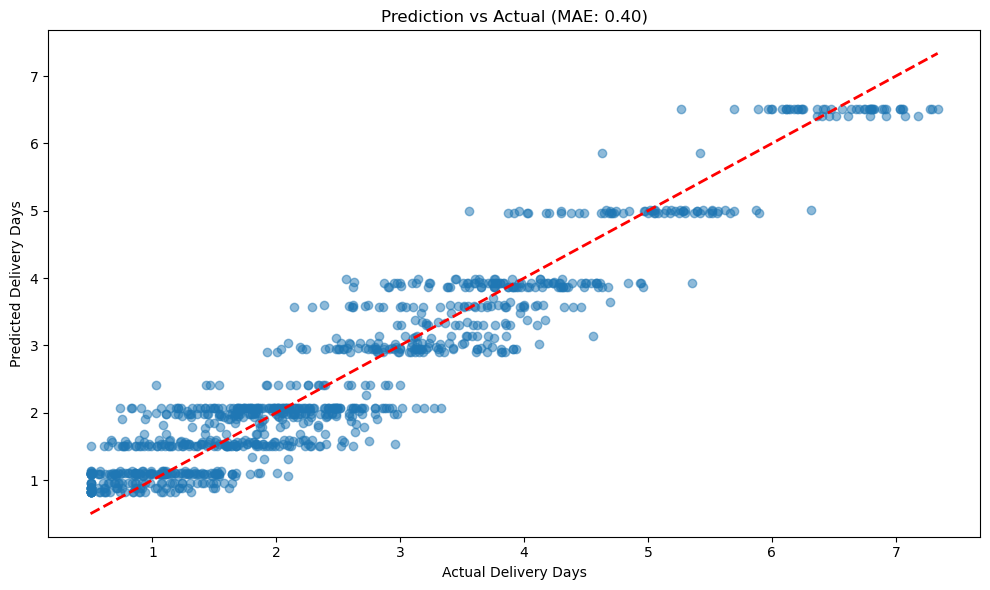

In [25]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Delivery Days')
plt.ylabel('Predicted Delivery Days')
plt.title(f'Prediction vs Actual (MAE: {mae:.2f})')
plt.tight_layout()
plt.savefig('prediction_scatter.png')
plt.show()

### The Feature Importance Chart

 shows which features (input variables) have the most influence on your model's predictions.

 What It Shows
- Y-axis: Feature names (e.g., distance, service_level, day_of_week)
- X-axis: Importance score (higher = more influential)

How Importance is Calculated
- For tree-based models (Random Forest, XGBoost, Extra Trees):
- Measures how much each feature reduces prediction error when used in splits
- Calculated by averaging across all trees in the ensemble
- Higher score = feature is used more frequently and in more important decision points

How to Interpret High Importance Features
- Example: distance has importance of 0.45
- Means: Distance is the strongest predictor of delivery time
- Action: Ensure this data is always accurate and available
- Business insight: Focus operational improvements on distance optimization

 

StatementMeta(, 5c6299cf-8d23-42ef-839e-a4db63519be4, 29, Finished, Available, Finished)

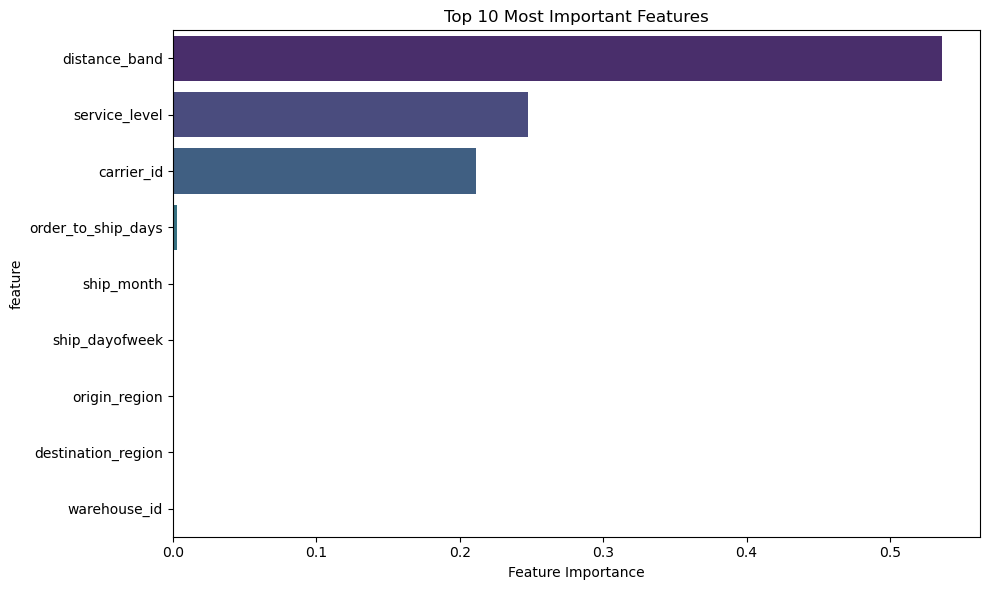

In [27]:
if hasattr(automl.model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': automl.model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='viridis')
    plt.title('Top 10 Most Important Features')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()